In [1]:
import spacy

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


/home/v.acampora/venv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-07 22:14:41.830476: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-07 22:14:42.559634: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
###################### carica dataset LDO 20-21 ############################ 

dataLDO2020 = pd.read_excel('/home/a.renda/to_move/LDO/filtrato_per_keyword/20-21_LDO_26K/LDO_20200101_20210101 pulito.ods', engine='odf')
dataLDO2021=pd.read_excel('/home/a.renda/to_move/LDO/filtrato_per_keyword/20-21_LDO_26K/LDO_20210101_20220101 pulito.ods', engine='odf')

# Filtra le righe che non contengono numeri (escludendo anche i NaN)
dataLDO2021 = dataLDO2021[dataLDO2021['nosologico'].astype(str).str.contains(r'\d')]
#rimosse 212 righe

In [3]:
print("\nColumns LDO 20-21:", dataLDO2020.columns)
print("\nColumns LDO 21-22:", dataLDO2021.columns)
print("\nShape LDO 20-21:", dataLDO2020.shape)
print("\nShape LDO 21-22:", dataLDO2021.shape)



Columns LDO 20-21: Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')

Columns LDO 21-22: Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')

Shape LDO 20-21: (24123, 17)

Shape LDO 21-22: (39274, 17)


In [4]:
######################## carica database filtrato ###############################

databaseFiltrato=pd.read_csv('/home/a.renda/to_move/LDO/labeled/20-21_341/DatabaseFiltrato.csv', sep=';')
print(databaseFiltrato.shape)
print(databaseFiltrato.columns) # la prima colonna è solo un contatore

# Filtra le righe che non contengono numeri (escludendo anche i NaN)
databaseFiltrato = databaseFiltrato[databaseFiltrato['nosologico'].astype(str).str.contains(r'\d')]

#tolte 5 righe

(26237, 3)
Index(['Unnamed: 0', 'nosologico', 'label'], dtype='object')


In [5]:
#################### filtra ldo 2020 ##########################

# Converti la colonna 'nosologico' del secondo dataset in int
databaseFiltrato['nosologico'] = pd.to_numeric(databaseFiltrato['nosologico'], errors='coerce')


# Trova i nosologici comuni
comuni2020 = dataLDO2020['nosologico'].isin(databaseFiltrato['nosologico'])

# Filtra il primo dataset
dataset_filtrato2020 = dataLDO2020[comuni2020]
print(dataset_filtrato2020.columns)
print(dataset_filtrato2020.shape)

Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')
(8974, 17)


In [ ]:
####################### filtra ldo 2021 ###########################

# Trova i nosologici comuni
comuni2021 = dataLDO2021['nosologico'].isin(databaseFiltrato['nosologico'])

# Filtra il primo dataset
dataset_filtrato2021 = dataLDO2021[comuni2021]
print(dataset_filtrato2021.columns)
print(dataset_filtrato2021.shape)

Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')
(17218, 17)


In [ ]:
######################## merge ldo2020 e ldo 2021 filtrati ###################################

merged_dataset = pd.concat([dataset_filtrato2020, dataset_filtrato2021], ignore_index=True) # non ci sono duplicati tra i due dataset 

# Risultato finale
print("\nColumns merged dataset:",merged_dataset.columns)
print("\nShape merged dataset:",merged_dataset.shape)
print(merged_dataset['testo'][0])



Columns merged dataset: Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')

Shape merged dataset: (26192, 17)
ObesitÃ  di classe III complicata da ipertensione arteriosa, insulino-resistenza con ridotta tolleranza glucidica, epatomegalia steatosica, insufficienza venosa arti inferiori, ipovitaminosi D e ernia iatale,colelitiasi trattata con colecistectomia,regredita a obesitÃ  di classe I dopo intervento chirurgico di bypass gastrico (2011) al peso di 142 Kg con persistenza di ipovitaminosi D, remissione delle comorbiditÃ  e comparsa di ipoglicemia reattiva sintomatica. Micronodulia tiroidea. Anemia microcitica ipocrocromica, sideropenica. Emorroidi congeste del canale anale.Terapia consigliata alla dimissione:Pr: Bariatrifast cpS: 1 cp ore 8.00Pr: Gl

In [8]:
###################### pulisci il testo: risoluzione di errori di codifica, sostituzione caratteri speciali #######################

import ftfy

# Applica ftfy.fix_text() a tutte le colonne di testo nel dataset, gestendo i valori non testuali
for col in merged_dataset.select_dtypes(include='object').columns:
    merged_dataset[col] = merged_dataset[col].apply(lambda x: ftfy.fix_text(x) if isinstance(x, str) else x)

In [9]:
######################## carica dataset con nosologici positivi #####################

Positivi= pd.read_excel('/home/a.renda/to_move/LDO/labeled/20-21_341/NosologiciPositivi_341.xlsx')

In [10]:
################################### aggiungere la colonna positivi #########################################

# Convertire la colonna 'Nosologico' in numerico nel dataset NosologiciPositivi
nosologici_positivi = pd.to_numeric(Positivi['NosologiciPositivi'], errors='coerce').dropna()

# Creare la colonna 'positivi' nel DataFrame merged_dataset
merged_dataset['positivi'] = merged_dataset['nosologico'].isin(nosologici_positivi).astype(int)


# Contare quanti 1 e quanti 0 ci sono nella colonna 'positivi'
count_positivi = merged_dataset['positivi'].value_counts()

# Stampa i risultati
print("\nConteggio dei valori nella colonna 'positivi':")
print(f"Numero di 1 (positivi): {count_positivi.get(1, 0)}")
print(f"Numero di 0 (non positivi): {count_positivi.get(0, 0)}")


Conteggio dei valori nella colonna 'positivi':
Numero di 1 (positivi): 341
Numero di 0 (non positivi): 25851


In [ ]:
################################

In [29]:
import GPUtil

def check_gpu_usage():
    gpu_stats = GPUtil.getGPUs()
    for gpu in gpu_stats:
        print(f"GPU {gpu.id} Memory Used: {gpu.memoryUsed} MB / {gpu.memoryTotal} MB")
        
check_gpu_usage()  # Stampa l'uso della memoria GPU prima e dopo ogni batch


GPU 0 Memory Used: 80988.0 MB / 81920.0 MB
GPU 1 Memory Used: 1978.0 MB / 81920.0 MB
GPU 2 Memory Used: 4086.0 MB / 81920.0 MB
GPU 3 Memory Used: 34116.0 MB / 81920.0 MB


In [ ]:
######################################

In [11]:
##################################### testo unico ##############################################

import pandas as pd
from datasets import load_dataset
from transformers import BertForMaskedLM, BertTokenizer
import torch
from datasets import Dataset

# Configura il dispositivo
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Specifica le colonne da unire
colonne_da_unire = ['testo', 'motivo_ricovero', 'anamnesi', 
                             'esameobiettivo', 'terapiafarmaingresso', 
                             'decorso', 'laboratorio', 'interventi', 
                             'followup', 'terapie2', 'terapie3', 
                             'esami', 'reparto']

# Rimuovi le interruzioni di riga da ogni colonna
merged_dataset[colonne_da_unire] = merged_dataset[colonne_da_unire].apply(lambda x: x.str.replace('\n', ' ', regex=False))

# Unisci solo le colonne specificate
merged_dataset['testo_unico'] = merged_dataset[colonne_da_unire].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)


# Salva il risultato in un file di testo
with open("dataset_medico.txt", "w", encoding="utf-8") as f:
    for text in merged_dataset['testo_unico']:
        f.write(text.strip() + "\n")


# Carica il modello e spostalo sulla GPU
model = BertForMaskedLM.from_pretrained("dbmdz/bert-base-italian-uncased").to(device)
# Carica il tokenizer
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-italian-uncased")


# Funzione per dividere un testo in frammenti di massimo 512 token
def split_into_chunks(text, tokenizer, max_length=512):
    tokens = tokenizer(text, truncation=False, add_special_tokens=False)['input_ids']
    chunks = [tokens[i:i+max_length] for i in range(0, len(tokens), max_length)]
    return chunks

# Segmenta il dataset
new_dataset = []
for row in merged_dataset['testo_unico']:  # Itera sui testi unici nel tuo dataset
    chunks = split_into_chunks(row, tokenizer)  # Dividi ogni testo in frammenti
    for chunk in chunks:  # Ricostruisci il testo da ogni frammento di token
        new_text = tokenizer.decode(chunk, skip_special_tokens=True)
        new_dataset.append({"text": new_text})  # Salva come dizionario per compatibilità con Hugging Face

# Converti il nuovo dataset in un formato compatibile con Hugging Face
hf_dataset = Dataset.from_list(new_dataset)

# Suddivisione in training e validation set (80-20)
dataset_split = hf_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_split['train']
val_dataset = dataset_split['test']

# Tokenizzazione
def tokenize_function(examples):
   return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=512)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=["text"])


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at dbmdz/bert-base-italian-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.den

Map: 100%|██████████| 23235/23235 [01:41<00:00, 228.36 examples/s]


In [18]:
print(f"Numero di esempi nel training set: {len(train_dataset)}")
print(f"Numero di esempi nel validation set: {len(val_dataset)}")

Numero di esempi nel training set: 92936
Numero di esempi nel validation set: 23235


In [12]:
######################################## PRE-TRAINING ######################################

import torch
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
from torch.optim import AdamW
import os
import time
from tqdm import tqdm

# Crea un dataloader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_train_dataset, batch_size=8, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(tokenized_val_dataset, batch_size=8, shuffle=False, collate_fn=data_collator)

# Ottimizzatore
optimizer = AdamW(model.parameters(), lr=5e-4)

# Directory per salvare i checkpoint
checkpoint_dir = "checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Parametri per Early Stopping
patience = 3
min_delta = 1e-4
best_val_loss = float('inf')
epochs_no_improve = 0
stop_training = False

# Numero di epoche totali
num_epochs = 10

# Controllo se esiste un checkpoint
checkpoint_path = os.path.join(checkpoint_dir, "latest_checkpoint.pt")
if os.path.exists(checkpoint_path):
    print(f"Caricamento del checkpoint da {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Riprendi dalla prossima epoca
    best_val_loss = checkpoint['best_val_loss']
    epochs_no_improve = checkpoint['epochs_no_improve']
else:
    start_epoch = 0

# Loop di training
for epoch in range(start_epoch, num_epochs):
    if stop_training:
        print(f"Early stopping attivato: interrompo il training dopo {epoch} epoche.")
        break

    print(f"Inizio dell'epoca {epoch + 1}")
    epoch_loss = 0  # Resetta la perdita per questa epoca
    model.train()

    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        # Assicurati che tutti i tensori siano sulla GPU
        inputs = {key: val.to(device) for key, val in batch.items()}

        # Aggiungi i labels (per Masked Language Modeling)
        labels = inputs["input_ids"].clone()
        labels[labels == tokenizer.pad_token_id] = -100
        inputs["labels"] = labels

        # Forward pass
        outputs = model(**inputs)
        loss = outputs.loss

        if loss is not None:
            epoch_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Salva checkpoint ogni 1000 step
        if step % 1000 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, "latest_checkpoint.pt")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'epochs_no_improve': epochs_no_improve,
            }, checkpoint_path)
            print(f"Checkpoint salvato: {checkpoint_path}")
            print(f"Epoch {epoch + 1}, Step {step}, Training Loss: {loss.item()}")

    epoch_loss /= len(train_dataloader)
    print(f"Epoch {epoch + 1} finished with loss: {epoch_loss}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            inputs = {key: val.to(device) for key, val in batch.items()}
            labels = inputs["input_ids"].clone()
            labels[labels == tokenizer.pad_token_id] = -100
            inputs["labels"] = labels

            outputs = model(**inputs)
            loss = outputs.loss

            if loss is not None:
                val_loss += loss.item()

            # Stampa ogni 1000 step
            if step % 1000 == 0:
                print(f"Epoch {epoch + 1}, Step {step}, Validation Loss: {loss.item()}")

    val_loss /= len(val_dataloader)
    print(f"Validation loss per l'epoca {epoch + 1}: {val_loss}")

    # Early Stopping e salvataggio del miglior modello
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        epochs_no_improve = 0
        print("Miglioramento trovato, salvataggio del modello...")
        model.save_pretrained("best_model")
        tokenizer.save_pretrained("best_model")
    else:
        epochs_no_improve += 1
        print(f"Nessun miglioramento per {epochs_no_improve} epoca(e).")

    if epochs_no_improve >= patience:
        print(f"Early stopping: nessun miglioramento per {patience} epoche consecutive.")
        stop_training = True

    # Salva checkpoint alla fine dell'epoca
    checkpoint_path = os.path.join(checkpoint_dir, "latest_checkpoint.pt")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'epochs_no_improve': epochs_no_improve,
    }, checkpoint_path)
    print(f"Checkpoint salvato: {checkpoint_path}")

    model.train()

# Salvataggio finale del modello
final_model_dir = "Med_bert_final"
model.save_pretrained(final_model_dir)
tokenizer.save_pretrained(final_model_dir)
print(f"Modello finale salvato a: {final_model_dir}")


Caricamento del checkpoint da checkpoints/latest_checkpoint.pt
Modello finale salvato a: Med_bert_final


In [ ]:
#################################### ottieni embedding senza troncamento ##############################

import torch
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

# Carica il modello e il tokenizer
model_name = "Med_bert_final"
model = AutoModel.from_pretrained(model_name).to("cuda:2")
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Assicurati che il modello sia in modalità di valutazione
model.eval()

# Parametri
batch_size = 16  # Regola in base alla memoria GPU disponibile
max_length = 512  # Lunghezza massima dei testi tokenizzati
column_embeddings = []  # Lista per contenere tutti gli embedding

# Colonne di testo da processare
columns = ['testo', 'motivo_ricovero', 'anamnesi', 
           'esameobiettivo', 'terapiafarmaingresso', 
           'decorso', 'laboratorio', 'interventi', 
           'followup', 'terapie2', 'terapie3', 
           'esami', 'reparto']

import torch
from tqdm import tqdm

def get_embeddings_with_window(text, tokenizer, model, window_size=512, overlap=128):
    # Tokenizza il testo senza troncamento
    tokens = tokenizer(text, return_tensors="pt", truncation=False)["input_ids"]
    embeddings = []

    # Usa una finestra mobile con sovrapposizione
    for start in range(0, len(tokens[0]), window_size - overlap):
        end = min(start + window_size, len(tokens[0]))
        window_tokens = tokens[:, start:end]

        # Estrai gli embeddings per la finestra corrente
        with torch.no_grad():
            outputs = model(window_tokens.to("cuda:2"))
            window_embeddings = outputs.last_hidden_state.mean(dim=1)  # Ottieni l'embedding medio per la finestra

            embeddings.append(window_embeddings)

    # Combina gli embedding delle finestre (media o concatenazione)
    # In questo caso, facciamo la media degli embedding delle finestre per ottenere un unico embedding per riga
    combined_embedding = torch.mean(torch.stack(embeddings), dim=0)  # Media lungo la dimensione delle finestre

    return combined_embedding

# Esegui l'elaborazione per ogni colonna
column_embeddings = []
for col in columns:
    print(f"Processing column: {col}")
    merged_dataset[col] = merged_dataset[col].astype(str)
    texts = merged_dataset[col].tolist()
    embeddings_list = []

    for i in tqdm(range(0, len(texts), batch_size), desc=f"Processing column '{col}'"):
        batch_texts = texts[i:i + batch_size]
        for text in batch_texts:
            # Estrai gli embedding usando la finestra mobile per ogni testo e combinali
            embeddings = get_embeddings_with_window(text, tokenizer, model)
            embeddings_list.append(embeddings)

    # Concatenazione finale dei batch per quella colonna
    column_embeddings_tensor = torch.stack(embeddings_list)  # Usando stack invece di cat per mantenere la struttura corretta
    # Rimuovi la dimensione extra che non serve
    column_embeddings_tensor = column_embeddings_tensor.squeeze(1)
    column_embeddings.append(column_embeddings_tensor)
    print(f"Column '{col}' processed: {column_embeddings_tensor.shape}")
    

# Concatenazione finale di tutti gli embedding
final_embeddings = torch.cat(column_embeddings, dim=1)
print(f"Final embeddings shape: {final_embeddings.shape}")


Some weights of BertModel were not initialized from the model checkpoint at Med_bert_final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing column: testo


Processing column 'testo': 100%|██████████| 1637/1637 [05:44<00:00,  4.75it/s]


Column 'testo' processed: torch.Size([26192, 768])
Processing column: motivo_ricovero


Processing column 'motivo_ricovero': 100%|██████████| 1637/1637 [05:18<00:00,  5.14it/s]


Column 'motivo_ricovero' processed: torch.Size([26192, 768])
Processing column: anamnesi


Processing column 'anamnesi': 100%|██████████| 1637/1637 [20:50<00:00,  1.31it/s] 


Column 'anamnesi' processed: torch.Size([26192, 768])
Processing column: esameobiettivo


Processing column 'esameobiettivo': 100%|██████████| 1637/1637 [06:27<00:00,  4.22it/s]


Column 'esameobiettivo' processed: torch.Size([26192, 768])
Processing column: terapiafarmaingresso


Processing column 'terapiafarmaingresso':  14%|█▍        | 228/1637 [01:04<08:33,  2.74it/s]

In [ ]:
#################################### ottieni embedding con troncamento ##############################

import torch
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm

# Carica il modello e il tokenizer
model_name = "Med_bert_final"
model = AutoModel.from_pretrained(model_name).to("cuda:2")
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Assicurati che il modello sia in modalità di valutazione
model.eval()

# Parametri
batch_size = 16  # Regola in base alla memoria GPU disponibile
max_length = 512  # Lunghezza massima dei testi tokenizzati
column_embeddings = []  # Lista per contenere tutti gli embedding

# Colonne di testo da processare
columns = ['testo', 'motivo_ricovero', 'anamnesi', 
           'esameobiettivo', 'terapiafarmaingresso', 
           'decorso', 'laboratorio', 'interventi', 
           'followup', 'terapie2', 'terapie3', 
           'esami', 'reparto']

for col in columns:
    print(f"Processing column: {col}")

    # Filtra solo le righe valide (testo non nullo)
    #merged_dataset = merged_dataset[merged_dataset[col].notnull()]

    # Converti i valori in stringa (se necessario)
    merged_dataset[col] = merged_dataset[col].astype(str)

    # Estrai i testi dalla colonna
    texts = merged_dataset[col].tolist()

    embeddings_list = []

    # Processa i dati a batch
    for i in tqdm(range(0, len(texts), batch_size), desc=f"Processing column '{col}'"):
        batch_texts = texts[i:i + batch_size]

        # Tokenizza e convertili in tensori
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to("cuda:2")

        # Estrai gli embedding
        with torch.no_grad():
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)  # Usa la media degli embedding

        embeddings_list.append(batch_embeddings)


    # Concatenazione dei batch in un'unica tensor
    column_embeddings_tensor = torch.cat(embeddings_list, dim=0)
    column_embeddings.append(column_embeddings_tensor)

    print(f"Column '{col}' processed: {column_embeddings_tensor.shape}")

# Concatenazione finale degli embedding
final_embeddings = torch.cat(column_embeddings, dim=1)
print(f"Final embeddings shape: {final_embeddings.shape}")


Some weights of BertModel were not initialized from the model checkpoint at Med_bert_final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing column: testo


Processing column 'testo': 100%|██████████| 1637/1637 [00:42<00:00, 38.97it/s]


Column 'testo' processed: torch.Size([26192, 768])
Processing column: motivo_ricovero


Processing column 'motivo_ricovero': 100%|██████████| 1637/1637 [00:25<00:00, 63.39it/s] 


Column 'motivo_ricovero' processed: torch.Size([26192, 768])
Processing column: anamnesi


Processing column 'anamnesi': 100%|██████████| 1637/1637 [02:14<00:00, 12.21it/s]


Column 'anamnesi' processed: torch.Size([26192, 768])
Processing column: esameobiettivo


Processing column 'esameobiettivo': 100%|██████████| 1637/1637 [01:00<00:00, 27.22it/s]


Column 'esameobiettivo' processed: torch.Size([26192, 768])
Processing column: terapiafarmaingresso


Processing column 'terapiafarmaingresso': 100%|██████████| 1637/1637 [00:39<00:00, 41.66it/s] 


Column 'terapiafarmaingresso' processed: torch.Size([26192, 768])
Processing column: decorso


Processing column 'decorso': 100%|██████████| 1637/1637 [02:34<00:00, 10.60it/s]


Column 'decorso' processed: torch.Size([26192, 768])
Processing column: laboratorio


Processing column 'laboratorio': 100%|██████████| 1637/1637 [01:49<00:00, 14.90it/s] 


Column 'laboratorio' processed: torch.Size([26192, 768])
Processing column: interventi


Processing column 'interventi': 100%|██████████| 1637/1637 [01:45<00:00, 15.57it/s]


Column 'interventi' processed: torch.Size([26192, 768])
Processing column: followup


Processing column 'followup': 100%|██████████| 1637/1637 [01:51<00:00, 14.70it/s]


Column 'followup' processed: torch.Size([26192, 768])
Processing column: terapie2


Processing column 'terapie2': 100%|██████████| 1637/1637 [00:26<00:00, 61.46it/s] 


Column 'terapie2' processed: torch.Size([26192, 768])
Processing column: terapie3


Processing column 'terapie3': 100%|██████████| 1637/1637 [01:22<00:00, 19.81it/s]


Column 'terapie3' processed: torch.Size([26192, 768])
Processing column: esami


Processing column 'esami': 100%|██████████| 1637/1637 [01:43<00:00, 15.88it/s]


Column 'esami' processed: torch.Size([26192, 768])
Processing column: reparto


Processing column 'reparto': 100%|██████████| 1637/1637 [00:20<00:00, 80.67it/s] 

Column 'reparto' processed: torch.Size([26192, 768])
Final embeddings shape: torch.Size([26192, 9984])


In [36]:
########################## CLASSIFIERS #################

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Definisci una lista di classificatori che vuoi provare
classifiers = {
    #'RandomForest': RandomForestClassifier(n_jobs=-1, max_depth=10, max_features=0.1, random_state=42),
    #'LogisticRegression': LogisticRegression(random_state=42, max_iter=200),
    #'SVM': SVC(probability=True,random_state=42),
    #'KNeighbors': KNeighborsClassifier(),
    #'DecisionTree': DecisionTreeClassifier(max_depth=10, random_state=42),
    #'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'extremeGradientBoosting': XGBClassifier( learning_rate=0.1, random_state=42, n_jobs=-1, max_depth=6),
}

In [37]:
######################## CROSS VALIDATION ########################

from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import numpy as np
import pandas as pd

def eval_cross_validation(pipeline, X, y, skf):
    list_reports = []
    list_auc = []  # Lista per raccogliere i valori di AUC
    list_num_features = []  # Lista per raccogliere il numero di features per ogni fold

    # Metriche aggregate per ogni classe
    precision_sum = {}
    recall_sum = {}
    f1_sum = {}
    support_sum = {}  # Per il calcolo del supporto medio

    # Liste per calcolare deviazioni standard
    precision_values = {}
    recall_values = {}
    f1_values = {}

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Addestra il pipeline
        pipeline.fit(X_train, y_train)

        # Previsioni e probabilità
        y_pred = pipeline.predict(X_val)
        y_pred_prob = pipeline.predict_proba(X_val)[:, 1]  # Probabilità della classe positiva

        # Classification report per il fold
        report = classification_report(y_val, y_pred, output_dict=True)
        list_reports.append(report)

        # AUC per il fold
        auc = roc_auc_score(y_val, y_pred_prob)
        list_auc.append(auc)

        # Numero di features (fisso per embedding precalcolati)
        num_features = X.shape[1]
        list_num_features.append(num_features)

        # Somma le metriche per ogni classe
        for label, metrics in report.items():
            if label not in ["accuracy", "macro avg", "weighted avg"]:
                precision_sum[label] = precision_sum.get(label, 0) + metrics["precision"]
                recall_sum[label] = recall_sum.get(label, 0) + metrics["recall"]
                f1_sum[label] = f1_sum.get(label, 0) + metrics["f1-score"]
                support_sum[label] = support_sum.get(label, 0) + metrics["support"]

                # Aggiungi i valori per la deviazione standard
                precision_values[label] = precision_values.get(label, []) + [metrics["precision"]]
                recall_values[label] = recall_values.get(label, []) + [metrics["recall"]]
                f1_values[label] = f1_values.get(label, []) + [metrics["f1-score"]]

    # Calcola le medie delle metriche
    num_folds = skf.get_n_splits()
    precision_avg = {label: precision_sum[label] / num_folds for label in precision_sum}
    recall_avg = {label: recall_sum[label] / num_folds for label in recall_sum}
    f1_avg_per_class = {label: f1_sum[label] / num_folds for label in f1_sum}
    support_avg = {label: support_sum[label] / num_folds for label in support_sum}

    # Calcola le deviazioni standard
    precision_std = {label: np.std(precision_values[label]) for label in precision_values}
    recall_std = {label: np.std(recall_values[label]) for label in recall_values}
    f1_std = {label: np.std(f1_values[label]) for label in f1_values}

    # Media di AUC e numero di features
    auc_avg = np.mean(list_auc)
    num_features_avg = np.mean(list_num_features)

    # Crea un DataFrame riassuntivo
    df_avg = pd.DataFrame({
        "Precision": precision_avg,
        "Recall": recall_avg,
        "F1-Score": f1_avg_per_class,
        "Support Avg": support_avg,  # Supporto medio
        "Precision Std": precision_std,
        "Recall Std": recall_std,
        "F1-Score Std": f1_std,
    })

    return df_avg, auc_avg, f1_avg_per_class, num_features_avg


# Configura StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)



### Modello: extremeGradientBoosting ###


/home/v.acampora/venv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v.acampora/venv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v.acampora/venv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v.acampora/venv2/lib/pyth

Classification report mediato:
   Precision    Recall  F1-Score  Support Avg  Precision Std  Recall Std  \
0    0.98698  0.999923  0.993409       2585.1       0.000113    0.000155   
1    0.00000  0.000000  0.000000         34.1       0.000000    0.000000   

   F1-Score Std  
0      0.000088  
1      0.000000  
AUC medio: 0.7829
Numero medio di features: 9984.00


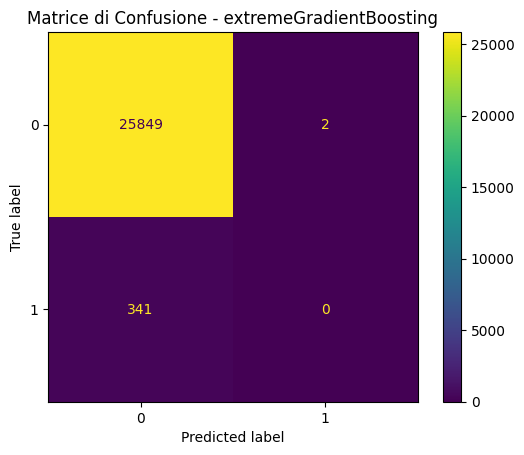

In [38]:
#################################### NO SMOTE ###################################

import spacy
import numpy as np
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline



# Esegui la cross-validation per ogni classificatore
for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")

    # Crea la pipeline per il classificatore corrente
    pipeline = Pipeline([('classificazione', clf)])

    # Usa gli embedding precalcolati
    X = final_embeddings.cpu().detach().numpy()  # Sposta i tensori sulla CPU e convertili in un array NumPy
    y = merged_dataset['positivi']

    # Fit della pipeline
    pipeline.fit(X, y)

    # Calcola le metriche usando la funzione (modifica per adattare alla tua funzione eval_cross_validation)
    df_avg, auc_avg, f1_avg_per_class, num_features_avg = eval_cross_validation(pipeline, X, y, skf)

    # Stampa i risultati
    print("Classification report mediato:")
    print(df_avg)
    print(f"AUC medio: {auc_avg:.4f}")
    print(f"Numero medio di features: {num_features_avg:.2f}")

    # Previsioni su tutto il dataset usando cross_val_predict
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)

    # Visualizza la matrice di confusione
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Matrice di Confusione - {clf_name}")
    plt.show()



### Modello: extremeGradientBoosting ###


Classification report mediato:
   Precision    Recall  F1-Score  Support Avg  Precision Std  Recall Std  \
0   0.987873  0.992611  0.990236       2585.1       0.000858    0.001016   
1   0.116179  0.076387  0.091746         34.1       0.094772    0.063418   

   F1-Score Std  
0      0.000749  
1      0.075352  
AUC medio: 0.7570
Numero medio di features: 9984.00


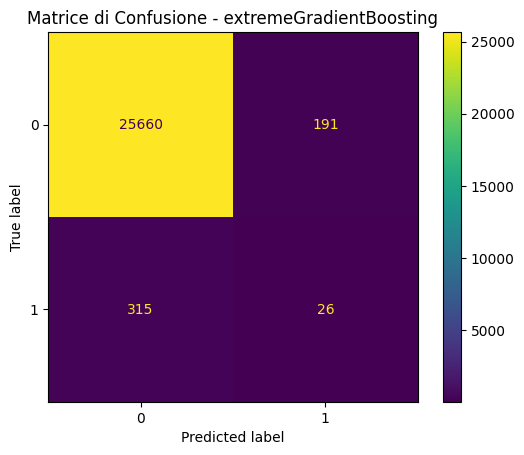

In [39]:
#################################### SMOTE ###################################

import spacy
import numpy as np
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


# Esegui la cross-validation per ogni classificatore
for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")

    # Crea la pipeline per il classificatore corrente
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('classificazione', clf)
    ])

    # Usa gli embedding precalcolati
    X = final_embeddings.cpu().detach().numpy()  # Sposta i tensori sulla CPU e convertili in un array NumPy
    y = merged_dataset['positivi']

    # Fit della pipeline
    pipeline.fit(X, y)

    # Calcola le metriche usando la funzione (modifica per adattare alla tua funzione eval_cross_validation)
    df_avg, auc_avg, f1_avg_per_class, num_features_avg = eval_cross_validation(pipeline, X, y, skf)

    # Stampa i risultati
    print("Classification report mediato:")
    print(df_avg)
    print(f"AUC medio: {auc_avg:.4f}")
    print(f"Numero medio di features: {num_features_avg:.2f}")

    # Previsioni su tutto il dataset usando cross_val_predict
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)

    # Visualizza la matrice di confusione
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Matrice di Confusione - {clf_name}")
    plt.show()



### Modello: extremeGradientBoosting ###
Classification report mediato:
   Precision    Recall  F1-Score  Support Avg  Precision Std  Recall Std  \
0   0.988157  0.990909  0.989531       2585.1       0.000629    0.001286   
1   0.130011  0.099832  0.112799         34.1       0.062675    0.044179   

   F1-Score Std  
0      0.000929  
1      0.051868  
AUC medio: 0.7739
Numero medio di features: 9984.00


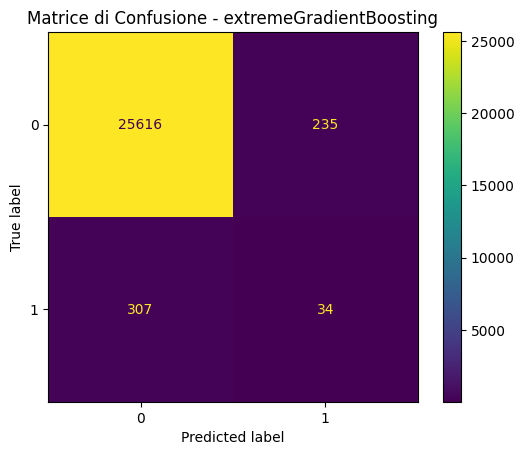

In [40]:
#################################### SMOTE + UNDERSAMPLING ###################################

import spacy
import numpy as np
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# Esegui la cross-validation per ogni classificatore
for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")

    # Crea la pipeline per il classificatore corrente
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42, sampling_strategy=0.6)),
        ('undersample', RandomUnderSampler(sampling_strategy=1.0, random_state=42)),
        ('classificazione', clf)
    ])

    # Usa gli embedding precalcolati
    X = final_embeddings.cpu().detach().numpy()  # Sposta i tensori sulla CPU e convertili in un array NumPy
    y = merged_dataset['positivi']

    # Fit della pipeline
    pipeline.fit(X, y)

    # Calcola le metriche usando la funzione (modifica per adattare alla tua funzione eval_cross_validation)
    df_avg, auc_avg, f1_avg_per_class, num_features_avg = eval_cross_validation(pipeline, X, y, skf)

    # Stampa i risultati
    print("Classification report mediato:")
    print(df_avg)
    print(f"AUC medio: {auc_avg:.4f}")
    print(f"Numero medio di features: {num_features_avg:.2f}")

    # Previsioni su tutto il dataset usando cross_val_predict
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)

    # Visualizza la matrice di confusione
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Matrice di Confusione - {clf_name}")
    plt.show()


In [ ]:
#################################### FINE TUNING

In [26]:
import os
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import AutoModel, AutoTokenizer, AdamW
from transformers import DataCollatorWithPadding
import torch.nn as nn
from tqdm import tqdm
import numpy as np

# Configurazione
model_name = "Med_bert_final"
device = "cuda:2"
batch_size = 4
epochs = 10
learning_rate = 2e-5
patience = 3
checkpoint_dir = "checkpoints"  # Directory per salvare i checkpoint
os.makedirs(checkpoint_dir, exist_ok=True)

# Dataset personalizzato
class MultiInputDataset(Dataset):
    def __init__(self, dataframe, columns, tokenizer, model, max_length, overlap):
        self.data = dataframe
        self.columns = columns
        self.tokenizer = tokenizer
        self.model = model
        self.max_length = max_length
        self.overlap = overlap

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = {}
        for col in self.columns:
            text = str(self.data.iloc[idx][col])
            # Ottieni gli embeddings per il testo completo
            embedding = get_embeddings_with_window(text, self.tokenizer, self.model, self.max_length, self.overlap)
            
            #item[col] = embedding
            #item[col] = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
            item[col] = {
                "input_ids": embedding["input_ids"],  # Embedding già presente
                "attention_mask": embedding["attention_mask"]  # Creiamo una mask di attenzione
            
            }
        item["labels"] = torch.tensor(self.data.iloc[idx]["positivi"], dtype=torch.long)
        return item

# Modello multi-input
class MultiInputBERT(nn.Module):
    def __init__(self, model_name, num_labels, num_columns):
        super(MultiInputBERT, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.num_columns = num_columns
        self.classifier = nn.Linear(self.bert.config.hidden_size * num_columns, num_labels)

    def forward(self, inputs_per_column):
        column_embeddings = []
        for col in inputs_per_column:
            input_ids = inputs_per_column[col]["input_ids"]
            attention_mask = inputs_per_column[col]["attention_mask"]
            
            # Assicurati che siano in batch form e abbiano la forma corretta
            input_ids = input_ids.to(device)  # Aggiungi il dispositivo (cuda)
            attention_mask = attention_mask.to(device)
            
            # Passa i tensori come input a BERT
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            column_embeddings.append(pooled_output)

        # Concatenare le rappresentazioni delle colonne
        combined_embeddings = torch.cat(column_embeddings, dim=1)
        logits = self.classifier(combined_embeddings)
        return logits
# Carica il tokenizer e il modello
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = MultiInputBERT(model_name=model_name, num_labels=2, num_columns=len(columns)).to(device)

# Dataset
dataset = MultiInputDataset(dataframe=merged_dataset, 
                            columns=columns, 
                            tokenizer=tokenizer, 
                            model=model,  # Passa l'oggetto modello, non il nome
                            max_length=512, 
                            overlap=128)

# Suddivisione in train e validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=data_collator)

# Ottimizzatore e funzione di perdita
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# Funzione per salvare il checkpoint
def save_checkpoint(epoch, model, optimizer, best_val_loss, checkpoint_dir):
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "best_val_loss": best_val_loss,
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

# Funzione per caricare il checkpoint
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    best_val_loss = checkpoint["best_val_loss"]
    print(f"Checkpoint loaded: {checkpoint_path} (Epoch {epoch}, Best Val Loss: {best_val_loss:.4f})")
    return epoch, best_val_loss

# Controlla se esistono checkpoint e riprendi
start_epoch = 0
best_val_loss = float("inf")
last_checkpoint = None
for file in os.listdir(checkpoint_dir):
    if file.startswith("checkpoint_epoch_"):
        last_checkpoint = os.path.join(checkpoint_dir, file)

if last_checkpoint:
    start_epoch, best_val_loss = load_checkpoint(last_checkpoint, model, optimizer)

# Early stopping
epochs_no_improve = 0
best_model_state = None

# Training loop con checkpointing
for epoch in range(start_epoch, epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} Training"):
        optimizer.zero_grad()
        inputs_per_column = {col: {k: v.to(device) for k, v in batch[col].items()} for col in columns}
        labels = batch["labels"].to(device)

        outputs = model(inputs_per_column)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1} Validation"):
            inputs_per_column = {col: {k: v.to(device) for k, v in batch[col].items()} for col in columns}
            labels = batch["labels"].to(device)

            outputs = model(inputs_per_column)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch + 1} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
        print(f"Validation loss improved to {val_loss:.4f}. Saving model and checkpoint...")
        save_checkpoint(epoch + 1, model, optimizer, best_val_loss, checkpoint_dir)
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epochs.")

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

# Salva il modello migliore
if best_model_state:
    torch.save(best_model_state, "fine_tuned_model.pth")
    print("Model saved as fine_tuned_model.pth")


Some weights of BertModel were not initialized from the model checkpoint at Med_bert_final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [42]:
from transformers import AutoTokenizer
import torch
from transformers import AutoModel
import torch.nn as nn

# Carica il modello e il tokenizer
model_name = "Med_bert_final"
model = AutoModel.from_pretrained(model_name).to("cuda:2")
tokenizer = AutoTokenizer.from_pretrained(model_name)

columns = [
    'testo', 'motivo_ricovero', 'anamnesi', 'esameobiettivo',
    'terapiafarmaingresso', 'decorso', 'laboratorio', 'interventi',
    'followup', 'terapie2', 'terapie3', 'esami', 'reparto'
]

# Prepara un dizionario con i dati di ogni colonna
texts_per_column = {col: merged_dataset[col].astype(str).tolist() for col in columns}
labels = merged_dataset["positivi"].tolist()


# Tokenizza ogni colonna
encodings_per_column = {
    col: tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
    for col, texts in texts_per_column.items()
}


class MultiInputDataset(torch.utils.data.Dataset):
    def __init__(self, encodings_per_column, labels):
        self.encodings_per_column = encodings_per_column
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {col: {key: val[idx] for key, val in encodings.items()}
                for col, encodings in self.encodings_per_column.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

dataset = MultiInputDataset(encodings_per_column, labels)


class MultiInputBERT(nn.Module):
    def __init__(self, model_name, num_labels, num_columns):
        super(MultiInputBERT, self).__init__()
        self.bert_models = nn.ModuleList([AutoModel.from_pretrained(model_name) for _ in range(num_columns)])
        self.classifier = nn.Linear(num_columns * 768, num_labels)  # 768 = hidden size di BERT

    def forward(self, inputs_per_column):
        # Elaborazione separata di ciascuna colonna
        embeddings = []
        for i, inputs in enumerate(inputs_per_column.values()):
            outputs = self.bert_models[i](**inputs)
            embeddings.append(outputs.pooler_output)  # Usa l'output della pooler di BERT

        # Combina gli embeddings delle colonne
        combined_embedding = torch.cat(embeddings, dim=1)  # Concatenazione lungo la dimensione delle features

        # Classificazione
        logits = self.classifier(combined_embedding)
        return logits


Some weights of BertModel were not initialized from the model checkpoint at Med_bert_final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
from transformers import AdamW
from torch.utils.data import DataLoader
from pathlib import Path

model = MultiInputBERT(
    model_name="Med_bert_final",
    num_labels=2,  # Per classificazione binaria
    num_columns=len(columns)
).to("cuda:2")

optimizer = AdamW(model.parameters(), lr=2e-5)


train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Ciclo di addestramento
epochs = 5
loss_fn = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        
        # Estrai input separati per ogni colonna
        inputs_per_column = {col: {key: val.to("cuda:2") for key, val in batch[col].items()}
                             for col in columns}
        labels = batch["labels"].to("cuda:2")

        # Passa i dati al modello
        outputs = model(inputs_per_column)
        loss = loss_fn(outputs, labels)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch + 1}: Loss = {loss.item()}")


# Cartella per salvare il modello
save_directory = Path("./fine_tuned_model")
save_directory.mkdir(parents=True, exist_ok=True)

# Salva il modello e il tokenizer
model.model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Fine-tuned model saved in {save_directory}")


Some weights of BertModel were not initialized from the model checkpoint at Med_bert_final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at Med_bert_final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at Med_bert_final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at Med_bert_final and are newly initialized: ['bert.pooler.dense.bias', 'be

Epoch 1: Loss = 0.013128709979355335
Epoch 2: Loss = 0.012615572661161423
Epoch 3: Loss = 0.005987281911075115
Epoch 4: Loss = 0.014340669848024845
Epoch 5: Loss = 0.00922650471329689


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Inference sul validation set
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in val_loader:  # Usa un DataLoader per il validation set
        inputs_per_column = {col: {key: val.to("cuda") for key, val in batch[col].items()} for col in columns}
        labels = batch["labels"].to("cuda")

        outputs = model(inputs_per_column)
        preds = torch.argmax(outputs, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Accuracy:", accuracy_score(true_labels, predictions))
print(classification_report(true_labels, predictions))
